## Alternate CNN technique to create image features

The purpose of this CNN dedicated notebook is to explore ability of CNN with transfer learning to provide usefull features for our classification engine feasibility study. <br/>
At this step, we discover VGG16 ImageNet and create vectors for each images, removing last layers.
We get an intermediate results (since further work on CNN technique would be to train this model to a desired set of images) that we can compare to other features created along the feasibility study. <br/>
Why a dedicated NB? because Keras - Tensorflow viable versions only operate in a separate Conda environment.

In [2]:
# opencv
import cv2
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import itertools
# get the path
import os
import os.path

In [4]:
# create original VGG16 model
original = VGG16()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



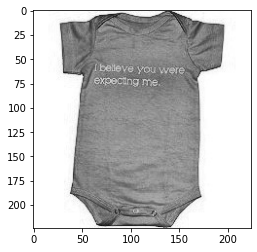

In [5]:
# set a sample image path
img_path = 'Data/SContrast_Images/46ca672fdfff8a1b3641642a9795344a.jpg'
# read and show
img = cv2.imread(img_path)
plt.imshow(img)

In [6]:
# convert to np array
img = img_to_array(img)

In [7]:
# create image - reshaped, preprocessed
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

In [8]:
# predict class (among 1000 in case of original imagenet)
class_predict_img = original.predict(img)

In [11]:
# display most likely predicted classes
print('Top 5 :', decode_predictions(class_predict_img, top=5)[0])

Top 5 : [('n04370456', 'sweatshirt', 0.44216326), ('n03595614', 'jersey', 0.35064897), ('n02916936', 'bulletproof_vest', 0.18512121), ('n04599235', 'wool', 0.0072465227), ('n03710637', 'maillot', 0.0020889202)]


In [12]:
# load VGG-16 imagenet pretrained entire version
conv_base = VGG16(
    weights="imagenet",
    include_top=True,
    pooling='max',
    input_shape=(224, 224, 3)
)

In [13]:
# original layers
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
# load VGG-16 imagenet pretrained without Top
conv_base = VGG16(
    weights="imagenet",
    include_top=False,
    pooling='max',
    input_shape=(224, 224, 3)
)

In [15]:
# layers until pooling (to get features)
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Having at last step a global_max_pooling2d is just fine for vector generation, (rather than a flatten layer we would have to put at end of CNN)

In [71]:
# get data['image']
data = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')

In [170]:
# extract features from VGG last pooling layer
img_dir = '/Users/etien/DataScience/P6/P6_ClassificationEngine/Data/SContrast_Images'
CNN_feature_512 = []
for index, row in data.iterrows():
    # get image name
    img_name = row['image']
    # create the path
    img_path = os.path.join(img_dir, img_name)
    # open image
    img = cv2.imread(img_path)
    # reshape img to get a tensor
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    # get the features
    features = conv_base.predict(img)
    features_flat = features.flatten()
    # add descriptors
    CNN_feature_512.append(features_flat)

In [175]:
# convert to dataframe
CNN_feature_512_df = pd.DataFrame(CNN_feature_512)

In [176]:
# store the results for further use
np.savetxt("data/features/vgg_512_results.csv", CNN_feature_512_df)

In [177]:
# overview
CNN_feature_512_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.906023,45.437290,23.123779,0.000000,21.838970,5.127982,49.428532,7.417574,0.000000,0.000000,...,26.707703,61.049484,10.869265,111.048866,7.778234,54.944973,24.359859,0.528392,1.085860,27.151415
1,0.000000,0.000000,0.000000,68.314056,0.000000,0.000000,4.263935,0.000000,0.000000,117.589691,...,161.879623,33.327255,0.000000,166.568451,51.041378,15.075288,160.811646,48.618710,38.278183,0.000000
2,13.305121,0.000000,18.931952,0.000000,13.631371,0.000000,89.679657,0.000000,10.527769,0.000000,...,20.681849,65.065483,31.144966,28.098335,113.427147,39.934235,85.832199,3.392960,9.637923,2.248572
3,41.539749,16.473944,0.000000,0.000000,0.000000,0.000000,22.571373,47.089096,0.000000,16.944534,...,129.747513,109.173126,0.000000,116.235580,126.301018,109.477585,140.973969,16.287941,75.318497,0.000000
4,65.332794,12.550014,0.000000,0.000000,0.000000,0.000000,45.263401,0.367472,0.000000,0.000000,...,42.247898,227.004166,0.000000,60.930878,106.111839,6.983478,164.517883,0.000000,41.179111,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,27.423830,0.000000,4.310802,0.000000,50.590057,0.000000,59.172150,53.435734,0.000000,76.396233,...,20.438160,50.031864,35.608593,79.728043,24.853741,53.008736,0.000000,66.527901,0.000000,42.669621
1046,7.400597,73.903046,44.972492,0.000000,83.525764,14.741640,15.381833,56.693741,0.000000,12.948579,...,144.163757,65.767975,19.116093,0.354342,14.894097,11.677193,0.000000,0.000000,0.000000,71.865158
1047,37.757252,34.401237,10.783236,19.725273,57.860851,43.727539,0.000000,2.974359,2.972992,17.474150,...,14.097606,55.298065,60.034039,17.787685,0.000000,29.166628,14.253839,15.296721,28.021126,67.972130
1048,52.072548,16.127823,18.007990,0.000000,0.000000,0.000000,2.553188,16.865055,0.000000,66.069542,...,100.503250,65.884811,0.000000,15.800812,37.681873,36.985241,28.401978,0.626492,2.474685,73.973831


Further step about CNN use for our classification engine : img generator, img augmentation and train (partial : fine tuning). <br/>
Note that it would required to switch to a more accurate feasbility study, with balanced mutli-labeled data.

In [57]:
# for potential further use (image generator)
img_datagen = ImageDataGenerator(
    rescale=1./255
)

In [97]:
# set image path, height and width
img_path = '/Users/etien/DataScience/P6/P6_ClassificationEngine/Data/Contrast_Images'
img_height, img_width = 224, 224

In [99]:
# generate images
img_generator = img_datagen.flow_from_directory(
    img_path,
    target_size = (img_height, img_width),
    class_mode=None)

Found 1050 images belonging to 7 classes.
